In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sky_spot.utils import ClusterType
from plot import *

sns.set_style('whitegrid')

InitMatplotlib(7, 7)


use_tex True 
font_size 7 
title_size 7


In [9]:
complete_str = ''
DATE = ''


TASK_DURATION_HOURS = 48
DDL = 60
gap_seconds = 600

# env_name = 'us-west-2b_k80_8' # Trace examples
OVERHEAD = 0.2

EXP_DIR = f'../../exp-for-plot/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={OVERHEAD:.2f}/real{complete_str}/'

In [19]:
strategies = {
    'Limited Deficit (plain)': f'rc_threshold-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}-keep_on_demand=1.0',
    'Limited Deficit': f'rc_cr_threshold-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}',
    'Optimal': f'ideal_ilp_overhead-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}',
    'Greedy': f'strawman-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}',
    'On-Demand': f'on_demand-deadline_hours={DDL:.1f}-task_duration_hours={TASK_DURATION_HOURS:.1f}',
}

statistics = []
for env_name in os.listdir(EXP_DIR):
    for strategy_name, strategy_folder in strategies.items():
        try:
            RESULTS_PATH = f'../../exp-for-plot/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={OVERHEAD:.2f}/real{complete_str}/{env_name}/{strategy_folder}/result.json'
            with open(RESULTS_PATH) as f:
                exp = json.load(f)['history']
                strategy_df = exp
            for i, h in enumerate(exp):
                df = pd.DataFrame.from_records(h)
                history = df['ClusterType'].to_numpy()
                history = np.array([0] + history.tolist() + [0])
                switch_to_spot = sum((history[1:] == ClusterType.SPOT.value) & (history[:-1] != ClusterType.SPOT.value))
                switch_to_vm = sum((history[1:] == ClusterType.ON_DEMAND.value) & (history[:-1] != ClusterType.ON_DEMAND.value))
                idle_time = sum(history[1:-1] == ClusterType.NONE.value)
                vm_time = sum(history[1:-1] == ClusterType.ON_DEMAND.value)
                spot_time = sum(history[1:-1] == ClusterType.SPOT.value)
                statistics.append(dict(
                    index=i,
                    env=env_name,
                    strategy=strategy_name,
                    switch_to_spot=switch_to_spot,
                    switch_to_vm=switch_to_vm,
                    idle_time=idle_time,
                    vm_time=vm_time,
                    spot_time=spot_time,
                    cost=df['Cost'].max() if 'Cost' in df else 0,
                ))
        except Exception as e:
            raise e
            print(e)
statistics_df = pd.DataFrame.from_records(statistics)        


In [8]:
statistics_df

,index,strategy,switch_to_spot,switch_to_vm,idle_time,vm_time,spot_time,cost
0,0,Limited Deficit (plain),17,12,37,124,198,95.352300
1,1,Limited Deficit (plain),18,8,22,115,203,91.573217
2,2,Limited Deficit (plain),17,6,36,98,216,85.011600
3,3,Limited Deficit (plain),19,8,39,50,269,69.127317
4,4,Limited Deficit (plain),24,11,32,121,206,95.119767
...,...,...,...,...,...,...,...,...
11995,295,On-Demand,0,1,1,290,0,147.900000
11996,296,On-Demand,0,1,1,290,0,147.900000
11997,297,On-Demand,0,1,1,290,0,147.900000
11998,298,On-Demand,0,1,1,290,0,147.900000


In [59]:
statistics_df.groupby(['strategy']).agg(['mean', 'std'])

/tmp/ipykernel_6319/1766562976.py:1: FutureWarning: ['env'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  statistics_df.groupby(['strategy']).agg(['mean', 'std'])


index            switch_to_spot            \
                          mean        std           mean       std   
strategy                                                             
Greedy                   149.5  86.620107       9.323750  7.190073   
Limited Deficit          149.5  86.620107      13.569583  6.687647   
Limited Deficit (plain)  149.5  86.620107      17.533333  8.526675   
On-Demand                149.5  86.620107       0.000000  0.000000   
Optimal                  149.5  86.620107      11.997500  7.142391   

                        switch_to_vm            idle_time             \
                                mean       std       mean        std   
strategy                                                               
Greedy                      0.830417  0.375345  52.648750  18.459095   
Limited Deficit             4.772500  2.990313  34.019583  14.725077   
Limited Deficit (plain)    12.273333  9.696664  22.970000  15.156236   
On-Demand                   1.000000  0.000000   1.000000   0.000000   
Optimal                     2.295417  1.829947  47.736667  15.252106   

                            vm_time               spot_time              \
                               mean         std        mean         std   
strategy                                                                  
Greedy                   185.813333  106.297208  114.340000  109.615168   
Limited Deficit          156.137500   94.121932  153.546667   92.511502   
Limited Deficit (plain)  151.055833   99.680274  171.049583   93.937793   
On-Demand                290.000000    0.000000    0.000000    0.000000   
Optimal                  126.855833   93.412142  178.506667   94.672701   

                               cost             
                               mean        std  
strategy                                        
Greedy                   113.308842  36.498155  
Limited Deficit          104.532835  33.121601  
Limited Deficit (plain)  104.779867  35.987891  
On-Demand                147.900000   0.000000  
Optimal                   93.647281  32.413055

In [20]:
processed_df = pd.DataFrame()
processed_df[['strategy', 'env',
              'index']] = statistics_df[['strategy', 'env', 'index']]
processed_df['Spot Delay'] = statistics_df['switch_to_spot'] * OVERHEAD
processed_df['On-Demand Delay'] = statistics_df['switch_to_vm'] * OVERHEAD
processed_df['Idle'] = statistics_df['idle_time'] * gap_seconds / 3600
processed_df['On-Demand'] = statistics_df['vm_time'] * gap_seconds / 3600 - processed_df[
    'On-Demand Delay']
processed_df['Spot'] = statistics_df['spot_time'] * gap_seconds / 3600 - processed_df['Spot Delay']

/tmp/ipykernel_6319/1730311898.py:8: FutureWarning: ['env'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agg_df = processed_df.groupby(['strategy']).agg(['mean', 'std'])


,strategy,index_mean,index_std,Spot Delay_mean,Spot Delay_std,On-Demand Delay_mean,On-Demand Delay_std,Idle_mean,Idle_std,Effective On-Demand Time,On-Demand_std,Effective Spot Time,Spot_std
4,Optimal,149.5,86.620107,2.399500,1.428478,0.459083,0.365989,7.956111,2.542018,20.683556,15.465383,27.351611,15.462055
1,Limited Deficit (Ours),149.5,86.620107,2.713917,1.337529,0.954500,0.598063,5.669931,2.454179,25.068417,15.322464,22.877194,15.370353
0,Greedy,149.5,86.620107,1.864750,1.438015,0.166083,0.075069,8.774792,3.076516,30.802806,17.656948,17.191917,17.659240


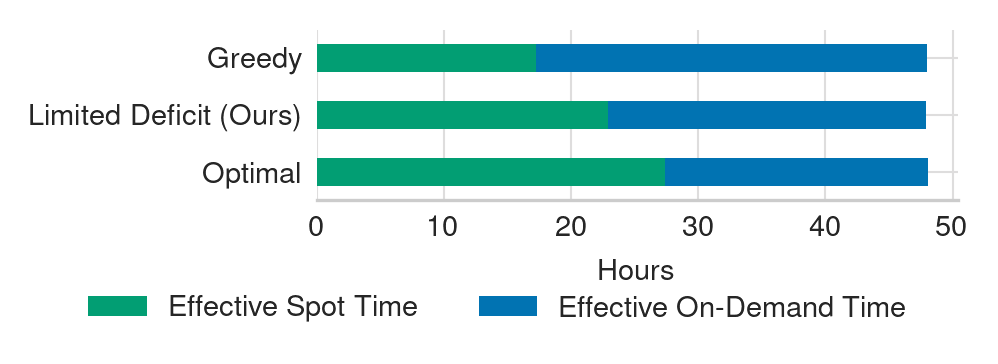

In [56]:
fig = plt.figure(dpi=300, figsize=(fig_width, fig_height - 1))
ax = fig.add_subplot(111)

color = sns.color_palette("colorblind")

palette = [color[2], color[0]]

agg_df = processed_df.groupby(['strategy']).agg(['mean', 'std'])
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df = agg_df.reset_index()

agg_df.loc[agg_df['strategy'] == 'Limited Deficit', 'strategy'] = 'Limited Deficit (Ours)'

strategies = ['Greedy', 'Limited Deficit (Ours)', 'Optimal']
agg_df = agg_df[agg_df['strategy'].isin(strategies)]
rename = {'Spot_mean': 'Effective Spot Time', 'On-Demand_mean': 'Effective On-Demand Time'}
agg_df.rename(columns=rename, inplace=True)

agg_df['strategy'] = pd.Categorical(agg_df['strategy'], categories=strategies, ordered=True)
agg_df.sort_values('strategy', inplace=True, ascending=False)

agg_df[['strategy', *rename.values()]].set_index('strategy').plot(kind='barh',
                                                      stacked=True,
                                                      xlabel='Hours',
                                                      ylabel='Strategy',
                                                      title=f'Time Breakdown',
                                                      ax=ax,
                                                      edgecolor='white',
                                                      linewidth=0,
                                                      
                                                      color=palette)
ax.legend().set_visible(False)
ax.set_title('')
ax.set_ylabel('')
handler_ax = ax
fig.legend(title='',
           loc='lower center',
           ncol=2,
           handles=handler_ax.get_legend_handles_labels()[0],
           bbox_to_anchor=(0.5, -0.1))

fig.tight_layout()
fig.savefig('figures/effective_time.pdf', bbox_inches='tight')
agg_df

In [11]:
aggregated = statistics_df.groupby('strategy').mean()


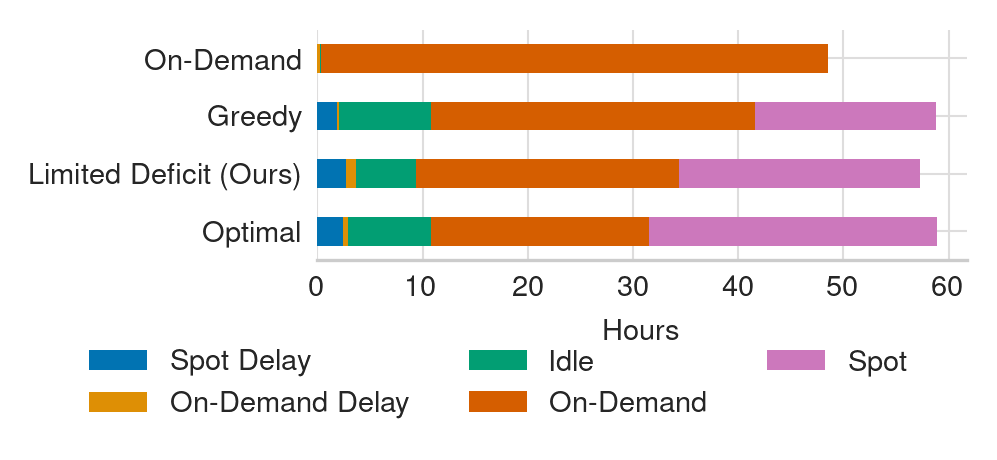

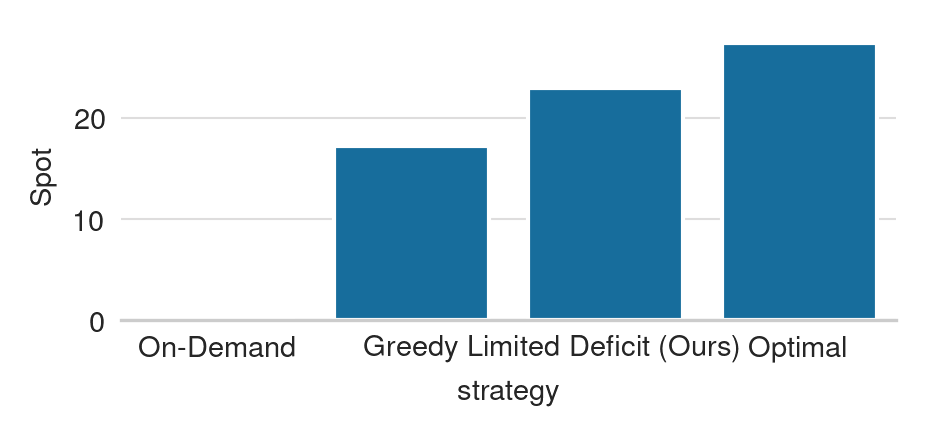

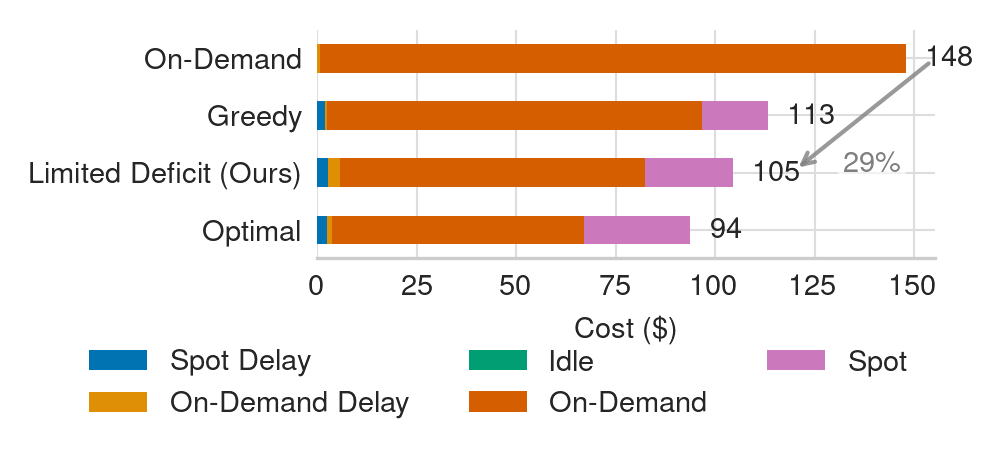

In [14]:
from sky_spot.utils import ACTUAL_COSTS


def add_total_annotations(ax, df):
    for i, strategy in enumerate(df.index):
        total_value = df.loc[strategy].sum()
        ax.annotate(f'{total_value:.0f}',
                    xy=(total_value, i),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center')


def add_arrow_and_percentage(ax, df, bar1_index, bar2_index):
    bar1_total = df.iloc[bar1_index].sum()
    bar2_total = df.iloc[bar2_index].sum()
    percentage_diff = (bar1_total - bar2_total) / bar1_total * 100

    arrow_shift = bar1_total / 10
    arrow_start_x = bar1_total + arrow_shift * 0.5
    arrow_start_y = bar1_index
    arrow_end_x = bar2_total + arrow_shift
    arrow_end_y = bar2_index

    ax.annotate("",
                xy=(arrow_end_x, arrow_end_y),
                xytext=(arrow_start_x, arrow_start_y),
                arrowprops=dict(arrowstyle="->", lw=1, color='gray',
                                alpha=0.8),
                annotation_clip=False)

    label_x = (arrow_start_x + arrow_end_x) / 2
    label_y = (arrow_start_y + arrow_end_y) / 2
    ax.annotate(f'{percentage_diff:.0f}\%',
                xy=(label_x, label_y),
                xytext=(-5, -15),
                textcoords='offset points',
                ha='left',
                va='bottom',
                color='gray',
                bbox=dict(facecolor='white',
                          alpha=0.6,
                          edgecolor='white',
                          boxstyle='round,pad=0.1'))


color = sns.color_palette('colorblind')
# color = sns.color_palette('pastel')
# fig = plt.figure(dpi=300, figsize=(fig_width, fig_height - .3))
fig = plt.figure(dpi=300, figsize=(fig_width, fig_height - .8))
ax = fig.add_subplot(111)
axes = [ax, ax]
# axes = fig.subplots(2, 1, sharey=True)
strategies = [
    'On-Demand', 'Greedy', 'Limited Deficit (plain)', 'Limited Deficit (Ours)',
    'Optimal'
]
strategies = ['On-Demand', 'Greedy', 'Limited Deficit (Ours)', 'Optimal']
df = pd.DataFrame()
df['Spot Delay'] = aggregated['switch_to_spot'] * OVERHEAD
df['On-Demand Delay'] = aggregated['switch_to_vm'] * OVERHEAD
df['Idle'] = aggregated['idle_time'] * gap_seconds / 3600
df['On-Demand'] = aggregated['vm_time'] * gap_seconds / 3600 - df[
    'On-Demand Delay']
df['Spot'] = aggregated['spot_time'] * gap_seconds / 3600 - df['Spot Delay']

df.reset_index(inplace=True)
df.loc[df['strategy'] == 'Limited Deficit',
       'strategy'] = 'Limited Deficit (Ours)'

df = df[df['strategy'].isin(strategies)]
# df.loc[df['strategy'] == 'spot', 'spot_hours'] = df.loc[df['strategy'] == 'spot', 'spot_hours'] + df.loc[df['strategy'] == 'spot', 'spot_overhead']
# df.loc[df['strategy'] == 'spot', 'spot_overhead'] = 0
df['strategy'] = pd.Categorical(df['strategy'], strategies)
df.sort_values('strategy', inplace=True, ascending=False)
df.set_index('strategy').plot(kind='barh',
                              stacked=True,
                              xlabel='Hours',
                              ylabel='Strategy',
                              title=f'Time Breakdown',
                              ax=axes[0],
                              edgecolor='white',
                              linewidth=0,
                              color=color)
# add_total_annotations(axes[0], df.set_index('strategy'))
axes[0].legend().set_visible(False)
axes[0].set_title('')
axes[0].set_ylabel('')
handler_ax = axes[0]
fig.legend(title='',
           loc='lower center',
           ncol=3,
           handles=handler_ax.get_legend_handles_labels()[0],
           bbox_to_anchor=(0.5, -0.18))
if DATE == '':
    fig.savefig(f'figures/time_breakdown.pdf', bbox_inches='tight')

# # fig.suptitle(f'Strategy Breakdown on {env_name} (d={OVERHEAD:.1f}h)')
fig.tight_layout()

fig = plt.figure(dpi=300, figsize=(fig_width, fig_height - .8))
ax = fig.add_subplot(111)
sns.barplot(data=df, x='strategy', y='Spot', ax=ax, color=color[0])



fig = plt.figure(dpi=300, figsize=(fig_width, fig_height - .8))
ax = fig.add_subplot(111)
axes = [ax, ax]

from sky_spot.utils import ClusterType, COSTS

spot_price = COSTS[ClusterType.SPOT]
vm_price = COSTS[ClusterType.ON_DEMAND]
if DATE != '':
    for device in ACTUAL_COSTS:
        if device in env_name:
            vm_price = ACTUAL_COSTS[device][0]
            spot_price = ACTUAL_COSTS[device][1]
            break
    else:
        raise

cost_df = pd.DataFrame()
cost_df['strategy'] = df['strategy']
cost_df['Spot Delay'] = df['Spot Delay'] * spot_price
cost_df['On-Demand Delay'] = df['On-Demand Delay'] * vm_price
cost_df['Idle'] = 0
cost_df['On-Demand'] = df['On-Demand'] * vm_price
cost_df['Spot'] = df['Spot'] * spot_price

cost_df.reset_index(inplace=True)
cost_df['strategy'] = pd.Categorical(cost_df['strategy'], strategies)
cost_df.sort_values('strategy', inplace=True, ascending=False)
cost_df.drop(columns=['index'], inplace=True)
cost_df.set_index('strategy').plot(kind='barh',
                                   stacked=True,
                                   xlabel='Cost',
                                   ylabel='Strategy',
                                   title=f'Cost Breakdown',
                                   ax=axes[1],
                                   edgecolor='white',
                                   linewidth=0,
                                   color=color)
add_total_annotations(axes[1], cost_df.set_index('strategy'))
add_arrow_and_percentage(axes[1], cost_df.set_index('strategy'), 3, 1)

axes[1].set_title('')
axes[1].set_ylabel('')
axes[1].set_xlabel(r'Cost (\$)')
for ax in axes:
    ax.legend().set_visible(False)

handler_ax = axes[0]
fig.legend(title='',
           loc='lower center',
           ncol=3,
           handles=handler_ax.get_legend_handles_labels()[0],
           bbox_to_anchor=(0.5, -0.18))

# fig.suptitle(f'Strategy Breakdown on {env_name} (d={OVERHEAD:.1f}h)')
fig.tight_layout()
if DATE == '2023-04-22-29':
    fig.savefig(f'figures/ml_breakdown.pdf', bbox_inches='tight')
elif DATE == '2023-04-19-29':
    fig.savefig(f'figures/spark_breakdown.pdf', bbox_inches='tight')
else:
    fig.savefig(f'figures/time_cost_breakdown.pdf', bbox_inches='tight')